In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/WHU19/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/WHU19/'.
There are 19 directories and 0 images in '/content/drive/MyDrive/WHU19/train'.
There are 0 directories and 43 images in '/content/drive/MyDrive/WHU19/train/Forest'.
There are 0 directories and 51 images in '/content/drive/MyDrive/WHU19/train/Meadow'.
There are 0 directories and 45 images in '/content/drive/MyDrive/WHU19/train/Airport'.
There are 0 directories and 40 images in '/content/drive/MyDrive/WHU19/train/footballField'.
There are 0 directories and 40 images in '/content/drive/MyDrive/WHU19/train/Beach'.
There are 0 directories and 41 images in '/content/drive/MyDrive/WHU19/train/Farmland'.
There are 0 directories and 42 images in '/content/drive/MyDrive/WHU19/train/Bridge'.
There are 0 directories and 42 images in '/content/drive/MyDrive/WHU19/train/Industrial'.
There are 0 directories and 40 images in '/content/drive/MyDrive/WHU19/train/Desert'.
There are 0 directories and 46 images in '/content/drive/MyDr

In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/WHU19/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Airport' 'Beach' 'Bridge' 'Commercial' 'Desert' 'Farmland' 'Forest'
 'Industrial' 'Meadow' 'Mountain' 'Park' 'Parking' 'Pond' 'Port'
 'Residential' 'River' 'Viaduct' 'footballField' 'railwayStation']


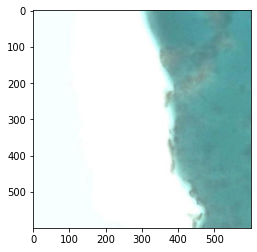

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread("/content/drive/MyDrive/WHU19/train/Beach/beach-11.jpg") # read in the chosen target image
plt.imshow(img) # plot the target image

In [ ]:
np.shape(img)

(600, 600, 3)

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (600, 600)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/WHU19/train"
valid_dir = "/content/drive/MyDrive/WHU19/valid"

train_datagen = ImageDataGenerator(rescale=1/1.)
valid_datagen = ImageDataGenerator(rescale=1/1.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Validation images:")
valid_data = valid_datagen.flow_from_directory(valid_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 814 images belonging to 19 classes.
Validation images:
Found 192 images belonging to 19 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(600, 600, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(19, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)


Shape after base_model: (None, 18, 18, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [ ]:
# Compile the model
model_0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_0 = model_0.fit(train_data,
                    epochs=20,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=int(0.25* len(valid_data)), # validate for less steps
                    )

Epoch 1/20
26/26 [==============================] - 32s 972ms/step - loss: 2.0524 - accuracy: 0.5516 - val_loss: 1.3996 - val_accuracy: 0.9062
Epoch 2/20
26/26 [==============================] - 23s 891ms/step - loss: 0.9258 - accuracy: 0.9275 - val_loss: 0.8028 - val_accuracy: 0.8750
Epoch 3/20
26/26 [==============================] - 23s 891ms/step - loss: 0.5329 - accuracy: 0.9484 - val_loss: 0.5262 - val_accuracy: 0.9375
Epoch 4/20
26/26 [==============================] - 23s 890ms/step - loss: 0.3817 - accuracy: 0.9582 - val_loss: 0.4827 - val_accuracy: 0.9062
Epoch 5/20
26/26 [==============================] - 23s 910ms/step - loss: 0.2882 - accuracy: 0.9693 - val_loss: 0.4839 - val_accuracy: 0.9062
Epoch 6/20
26/26 [==============================] - 23s 888ms/step - loss: 0.2370 - accuracy: 0.9742 - val_loss: 0.3891 - val_accuracy: 0.9688
Epoch 7/20
26/26 [==============================] - 23s 888ms/step - loss: 0.2011 - accuracy: 0.9791 - val_loss: 0.4081 - val_accuracy: 0.9062

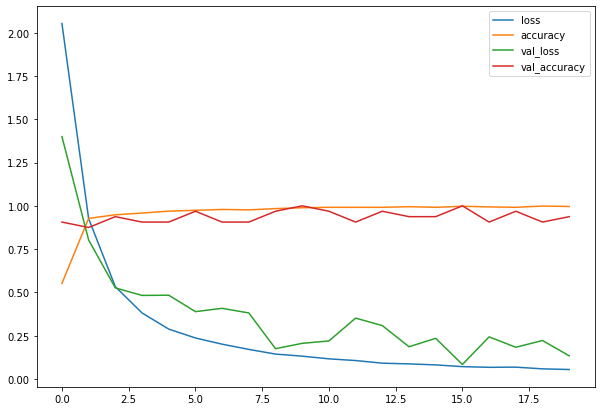

In [ ]:
import pandas as pd
pd.DataFrame(history_0.history).plot(figsize=(10, 7));

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=600):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  ## Rescale the image (get all values between 0 and 1)
 # img = img/255.
  return img

In [ ]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


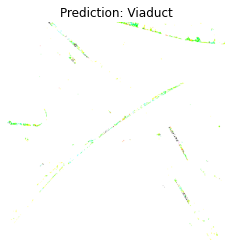

In [ ]:
pred_and_plot(model=model_0, 
              filename="/content/drive/MyDrive/WHU19/valid/Viaduct/viaduct_01.jpg", 
              class_names=class_names)

In [ ]:
# Save a model
model_0.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
